In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
# Statistical analysis
from scipy import stats
# Model training and evaluation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
# Utility
from datetime import datetime
import joblib
import json

In [ ]:
# crop_data = pd.read_excel('/content/drive/MyDrive/model dvpt data/crop_recommendation.xlsx', sheet_name=0)

In [ ]:
region_data = pd.read_excel('sample_data/crop_recommendations.xlsx', sheet_name=2)
crop_data = pd.read_csv('sample_data/filtered_crop_suitability_dataset.csv')


In [ ]:
# crop_data = pd.read_excel('/content/drive/MyDrive/model dvpt data/crop_recommendations.xlsx', sheet_name=0)
# region_data = pd.read_excel('/content/drive/MyDrive/model dvpt data/crop_recommendations.xlsx', sheet_name=2)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # Function to sample a value from a range or threshold
# def sample_from_range(value):
#     # Remove commas from numbers
#     if isinstance(value, str):
#         value = value.replace(',', '')

#     # Check if the value is a range (e.g., '45-60')
#     if isinstance(value, str) and '-' in value:
#         parts = value.split('-')
#         if len(parts) == 2 and all(part.strip().replace('.', '', 1).isdigit() for part in parts):
#             low, high = map(float, parts)
#             return np.random.uniform(low, high)

#     # Check for '>' or '<' in the value, e.g., '>60' or '<45'
#     if isinstance(value, str) and value:
#         if value[0] == '>':
#             threshold = float(value[1:].strip())
#             return np.random.uniform(threshold, threshold + 20)  # Sample within a range above the threshold
#         elif value[0] == '<':
#             threshold = float(value[1:].strip())
#             return np.random.uniform(threshold - 20, threshold)  # Sample within a range below the threshold

#     # Check for symbol at the end (e.g., '50<')
#     if isinstance(value, str) and value[-1] == '<':
#         threshold = float(value[:-1].strip())  # Remove the '<' symbol and convert to float
#         return np.random.uniform(threshold - 20, threshold)  # Sample within a range below the threshold

#     # Check if the value is a valid number after removing commas
#     if isinstance(value, str) and value.replace('.', '', 1).isdigit():
#         return float(value)  # Return as float after removing commas

#     return value

# # Function to generate samples for each crop
# def generate_samples(data, num_samples=100):
#     sampled_data = []
#     for _, row in data.iterrows():
#         for _ in range(num_samples):
#             sampled_row = row.copy()
#             sampled_row['Altitude (masl)'] = sample_from_range(row['Altitude (masl)'])
#             sampled_row['temperature (C) '] = sample_from_range(row['temperature (C) '])
#             sampled_row['pH'] = sample_from_range(row['pH'])
#             sampled_row['Crop water need (mm/total growing period)'] = sample_from_range(row['Crop water need (mm/total growing period)'])
#             sampled_row['Humidity(%)'] = sample_from_range(row['Humidity(%)'])
#             sampled_row['N'] = sample_from_range(row['N'])
#             sampled_row['P'] = sample_from_range(row['P'])
#             sampled_row['K'] = sample_from_range(row['K'])
#             sampled_data.append(sampled_row)
#     return pd.DataFrame(sampled_data)

# # Generate the new sampled dataset
# sampled_dataset = generate_samples(crop_data, num_samples=100)


sampled_dataset = crop_data

In [ ]:
crop_columns_to_remove = [
    'Id','Crop suitability','Growing period (days)','Irrigation required(%)'
]

sampled_dataset = sampled_dataset.drop(columns=crop_columns_to_remove, errors='ignore')

In [ ]:
models = {

    'XGBoost': XGBClassifier(
        n_estimators=200,                # Increase number of boosting rounds
        learning_rate=0.05,              # Lower learning rate
        max_depth=4,                     # Decrease max depth to avoid overfitting
        min_child_weight=3,              # Minimum sum of instance weight needed in a child
        gamma=0.1,                       # Minimum loss reduction required to split
        subsample=0.8,                   # Fraction of samples used for training each tree
        colsample_bytree=0.8,            # Fraction of features used for training each tree
        reg_lambda=1.5,                  # L2 regularization
        reg_alpha=0.5,                   # L1 regularization (adds sparsity)
        eval_metric='mlogloss',
        random_state=42
    )
}

In [ ]:
# Prepare the dataset for training
train_features = sampled_dataset[['Altitude (masl)', 'temperature (C) ',
                             'pH', 'N', 'P', 'K','Crop water need (mm/total growing period)', 'Humidity(%)']]
target = sampled_dataset['Crop']

In [ ]:
# Encode the target variable to numerical values
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_features, target_encoded, test_size=0.2, random_state=42)

In [ ]:
# Initialize model_accuracies
model_accuracies = {name: [] for name in models.keys()}

In [ ]:
# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"Training {name}...")
        try:
            # Train the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            print(f"\n{name} Accuracy: {accuracy:.4f}")

            # Calculate classification report
            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

            # Store results
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'classification_report': report
            }

            # Append the accuracy to the model_accuracies list
            model_accuracies[name].append(accuracy)

        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            results[name] = {
                'model': None,
                'accuracy': None,
                'classification_report': None,
                'error': str(e)
            }

    return results

# Train and evaluate all models
results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

# Calculate mean accuracies
mean_accuracies = {
    model_name: (sum(accuracies) / len(accuracies)) if len(accuracies) > 0 else 0
    for model_name, accuracies in model_accuracies.items()
}

# Determine the best model
best_model_name = max(mean_accuracies, key=mean_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name} with mean accuracy: {mean_accuracies[best_model_name]:.4f}")

Training XGBoost...

XGBoost Accuracy: 0.9895

Best Model: XGBoost with mean accuracy: 0.9895


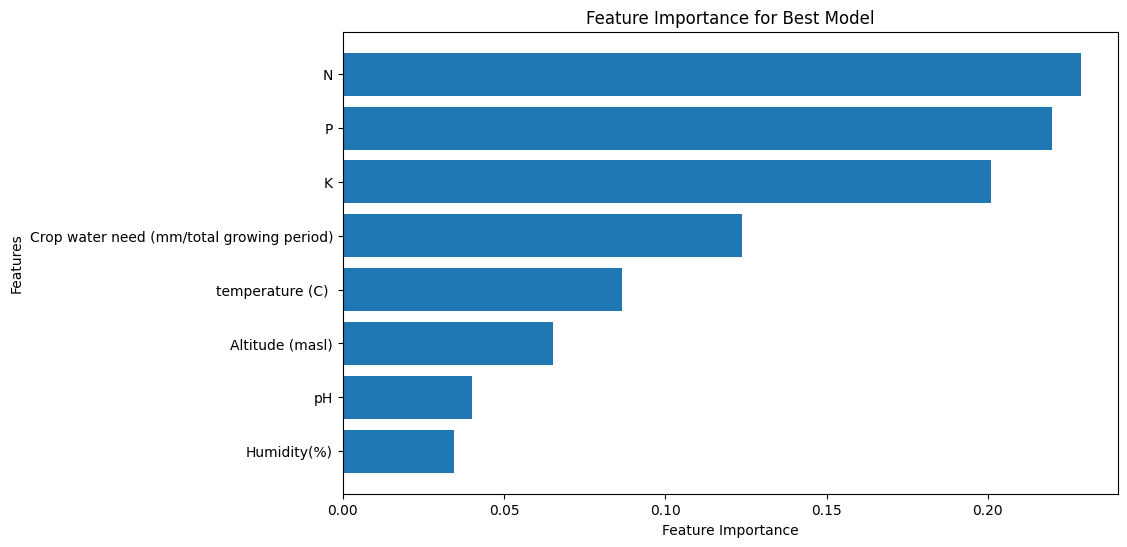

In [ ]:
feature_importance = best_model.feature_importances_

feature_names = train_features.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Best Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Step 1: Drop rows with specific unwanted text entries
unwanted_text = ['Protected Land', 'Water Body']
region_data = region_data[~region_data['pH'].isin(unwanted_text)]

# Step 2: Function to calculate average pH
def calculate_average_ph(ph_value):
    # Handle special case for values like '<5.0'
    if '<' in ph_value:
        # Convert '<5.0' to 5.0 (assuming '<5.0' means "up to 5.0")
        return float(ph_value.replace('<', ''))
    elif '>' in ph_value:
        return float(ph_value.replace('>',''))

    # Handle range values like '6.0-7.0'
    if '-' in ph_value:
        lower, upper = map(float, ph_value.split('-'))
        return (lower + upper) / 2

    # Convert single numeric value to float
    return float(ph_value)

# Step 3: Apply the function to the 'pH' column
region_data['pH_avg'] = region_data['pH'].apply(calculate_average_ph)

<ipython-input-696-05840f39a02f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['pH_avg'] = region_data['pH'].apply(calculate_average_ph)


In [ ]:
def fetch_crop_data(crop_names, dataset):
    # Filter the dataset based on the crop names
    filtered_data = dataset[dataset['Crop'].isin(crop_names)].drop_duplicates(subset=['Crop'])

    # Use a dictionary to store crop details for quick lookup
    crop_details_dict = {}
    for _, row in filtered_data.iterrows():
        crop_details_dict[row['Crop']] = {
            "season_a_start": row['Season A start(month)'],
            "season_a_end": row['Season A end'],
            "season_b_start": row['Season B start(month)'],
            "season_b_end": row['Season B end(month)'],
            "soil_type": row['Soil type']
        }

    return crop_details_dict

In [ ]:
def extract_monthly_avg(data, start_month, end_month, col_prefix):
    # Ensure that start_month and end_month are integers
    start_month = int(start_month)
    end_month = int(end_month)

    print(f"DEBUG: start_month (after conversion) = {start_month}")
    print(f"DEBUG: end_month (after conversion) = {end_month}")

    # Generate month indices based on the start and end months
    if start_month <= end_month:
        month_indices = list(range(start_month, end_month + 1))
    else:  # Handle case where the period spans the year-end (e.g., Nov to Feb)
        month_indices = list(range(start_month, 13)) + list(range(1, end_month + 1))

    print(f"DEBUG: Generated month_indices = {month_indices}")

    # Extract relevant column names based on the month indices
    monthly_columns = [f"{col_prefix} - {datetime(1900, month, 1).strftime('%b')}" for month in month_indices]

    print(f"DEBUG: Extracted monthly_columns = {monthly_columns}")

    # Calculate the average of the selected months
    avg_value = data[monthly_columns].mean(axis=1).values[0]

    print(f"DEBUG: Calculated avg_value = {avg_value}")
    return avg_value


In [ ]:
# def get_month_avg(region_data, start_date):
#     """Get average temperature, rainfall, and crop water need based on the month of the start date."""
#     start_month = datetime.strptime(start_date, "%Y-%m-%d").month
#     print(f"DEBUG: start_date = {start_date}, parsed start_month = {start_month}")

#     # Extract the relevant columns for the selected month
#     avg_temperature = extract_monthly_avg(region_data, start_month, start_month, "Average Temperature (°C)")
#     avg_rainfall = extract_monthly_avg(region_data, start_month, start_month, "Average Precipitation (mm)")

#     print(f"DEBUG: Avg temperature for month {start_month}: {avg_temperature}")
#     print(f"DEBUG: Avg rainfall for month {start_month}: {avg_rainfall}")

#     return avg_temperature, avg_rainfall

In [ ]:
# Define the mapping of months to seasons
SEASON_MAP = {
    'A': [9, 10, 11, 12, 1],  # September to January
    'B': [2, 3, 4, 5, 6],     # February to June
    'C': [7, 8]               # July to August
}

def get_season_from_month(month):
    """Determine the season based on the given month."""
    for season, months in SEASON_MAP.items():
        if month in months:
            return season
    return None

def get_month_avg(region_data, start_date):
    """Get average temperature and total rainfall based on the season of the start date."""
    start_month = datetime.strptime(start_date, "%Y-%m-%d").month
    print(f"DEBUG: start_date = {start_date}, parsed start_month = {start_month}")

    # Determine the season for the given month
    season = get_season_from_month(start_month)
    print(f"DEBUG: Season for month {start_month}: {season}")

    if not season:
        raise ValueError("Invalid month provided, unable to determine season.")

    # Get the list of months for the identified season
    season_months = SEASON_MAP[season]

    # Calculate the average temperature for the season
    avg_temperature = extract_monthly_avg(region_data, season_months[0], season_months[-1], "Average Temperature (°C)")

    # Calculate the total rainfall for the season manually
    total_rainfall = 0
    for month in season_months:
        monthly_rainfall = extract_monthly_avg(region_data, month, month, "Average Precipitation (mm)")
        if monthly_rainfall is not None:
            total_rainfall += monthly_rainfall

    print(f"DEBUG: Avg temperature for season {season}: {avg_temperature}")
    print(f"DEBUG: Total rainfall for season {season}: {total_rainfall}")

    return avg_temperature, total_rainfall

In [ ]:
# User input
# user_input = {
#     "district": "Nyanza",
#     "sector": "Mukingo",
#     "start_date_to_plant": "2024-03-01"
# }


user_input = {
    # "start_date_to_plant": "2024-02-18",  # Example start date
    "Altitude (masl)": 2200,             # Altitude in meters above sea level
    "temperature (C)": 23.5,             # Temperature in Celsius
    "pH": 6.5,                           # Soil pH level
    "N": 140,                            # Nitrogen percentage
    "P": 20,                             # Phosphorus in ppm
    "K": 200,                            # Potassium in ppm
    "rainfall": 2800,  # Rainfall in mm
    "Humidity(%)": 70                    # Humidity percentage
}

In [ ]:
def predict_best_crops(features, best_model, label_encoder, top_n=5):
    """Predict top crops based on input features."""
    features_df = pd.DataFrame([features])

    print("\nDEBUG: Input features for prediction:")
    print(features_df)

    # Ensure the feature order matches the model's training data
    feature_columns = [
        'Altitude (masl)', 'temperature (C) ', 'pH', 'N', 'P', 'K',
        'Crop water need (mm/total growing period)', 'Humidity(%)'
    ]
    features_df = features_df[feature_columns]

    # Make a prediction using the best model
    try:
        predictions_proba = best_model.predict_proba(features_df)[0]
        print("\nDEBUG: Prediction probabilities:", predictions_proba)
    except AttributeError as e:
        print("\nDEBUG: Model does not support predict_proba. Error:", str(e))
        predicted_class = best_model.predict(features_df)[0]
        return [label_encoder.inverse_transform([predicted_class])[0]]

    # Get the indices of the top N predictions with the highest probability
    top_n_indices = np.argsort(predictions_proba)[-top_n:][::-1]

    # Get the crop names and their corresponding probabilities
    top_crops = label_encoder.inverse_transform(top_n_indices)
    top_probabilities = predictions_proba[top_n_indices]

    print("\nDEBUG: Top crops and their probabilities:")
    for crop, prob in zip(top_crops, top_probabilities):
        print(f"Crop: {crop}, Probability: {prob}")

    # Return both top crops and their probabilities
    return list(zip(top_crops, top_probabilities))


In [ ]:
# Helper function to convert non-serializable types
def convert_to_serializable(obj):
    if isinstance(obj, np.int64):
        return int(obj)  # Convert to native Python int
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

**Location based**

In [ ]:
# # Filter region data based on user input
# filtered_region = region_data[
#     (region_data['District'] == user_input['district']) &
#     (region_data['Sector'] == user_input['sector'])
# ]

# # Check if filtered_region is empty
# if filtered_region.empty:
#     print("\nDEBUG: No data found for the specified district and sector.")
# else:
#     print("\nDEBUG: Filtered region data found.")
#     print(filtered_region)

#     # Extract relevant features from the filtered region
#     humidity = filtered_region['Humidity(%)'].values[0].item()
#     pH = filtered_region['pH_avg'].values[0].item()
#     potassium_min = filtered_region['Potassium(ppm)'].values[0].item()
#     phosphorus_min = filtered_region['Phosphorus(ppm)'].values[0].item()
#     nitrogen = filtered_region['Nitrogen(%)'].values[0].item()
#     altitude = filtered_region['Elevation'].values[0].item()

#     print("\nDEBUG: Extracted features:")
#     print(f"Humidity: {humidity}, pH: {pH}, K: {potassium_min}, P: {phosphorus_min}, N: {nitrogen}, Altitude: {altitude}")

#     # Calculate temperature and rainfall based on the provided start date
#     temperature, rainfall = get_month_avg(
#         filtered_region,
#         user_input['start_date_to_plant']
#     )

#     # Prepare the features for the model
#     features = {
#         'Altitude (masl)': altitude,
#         'temperature (C) ': temperature,
#         'pH': pH,
#         'N': nitrogen,
#         'P': phosphorus_min,
#         'K': potassium_min,
#         'Crop water need (mm/total growing period)': rainfall,
#         'Humidity(%)': humidity
#     }

#     print("\nDEBUG: Final features for prediction:")
#     print(features)

#     # Predict the top 5 crops along with their probabilities
#     top_crops = predict_best_crops(features, best_model, label_encoder)

#     # Extract crop names for querying additional data from the dataset
#     crop_names = [crop for crop, _ in top_crops]

#     # Fetch additional data for the predicted crops
#     crop_details = fetch_crop_data(crop_names, sampled_dataset)

#     # Format the output in JSON
#     output = {
#         "predicted_crops": [
#             {
#                 "crop_name": crop,
#                 "probability": float(probability),
#                 **crop_details.get(crop, {})  # Merge details if available
#             }
#             for crop, probability in top_crops
#         ]
#     }

#     # Print the output in JSON format
#     print("\nDEBUG: Final output:")
#     # Convert the output dictionary before serializing
#     output_serializable = convert_to_serializable(output)

#     # Now serialize to JSON
#     print(json.dumps(output_serializable, indent=4))

**User inputs**

In [ ]:
# Prepare the features for the model using the fixed values
features = {
    'Altitude (masl)': user_input['Altitude (masl)'],
    'temperature (C) ': user_input['temperature (C)'],
    'pH': user_input['pH'],
    'N': user_input['N'],
    'P': user_input['P'],
    'K': user_input['K'],
    'Crop water need (mm/total growing period)': user_input['rainfall'],
    'Humidity(%)': user_input['Humidity(%)']
}

print("\nDEBUG: Final features for prediction:")
print(features)

# Predict the top 5 crops along with their probabilities
top_crops = predict_best_crops(features, best_model, label_encoder)

# Extract crop names for querying additional data from the dataset
crop_names = [crop for crop, _ in top_crops]

# Fetch additional data for the predicted crops
crop_details = fetch_crop_data(crop_names, sampled_dataset)

# Format the output in JSON
output = {
    "predicted_crops": [
        {
            "crop_name": crop,
            "probability": float(probability),
            **crop_details.get(crop, {})  # Merge details if available
        }
        for crop, probability in top_crops
    ]
}

# Print the output in JSON format
print("\nDEBUG: Final output:")
output_serializable = convert_to_serializable(output)
print(json.dumps(output_serializable, indent=4))


DEBUG: Final features for prediction:
{'Altitude (masl)': 2200, 'temperature (C) ': 23.5, 'pH': 6.5, 'N': 140, 'P': 20, 'K': 200, 'Crop water need (mm/total growing period)': 2800, 'Humidity(%)': 70}

DEBUG: Input features for prediction:
   Altitude (masl)  temperature (C)    pH    N   P    K  \
0             2200              23.5  6.5  140  20  200   

   Crop water need (mm/total growing period)  Humidity(%)  
0                                       2800           70  

DEBUG: Prediction probabilities: [0.00987251 0.00172183 0.0012225  0.00214637 0.00163207 0.00824898
 0.00120424 0.00150181 0.00107688 0.00755612 0.00134038 0.0012413
 0.00139662 0.00140505 0.00109284 0.0009177  0.91345054 0.04179749
 0.00117477]

DEBUG: Top crops and their probabilities:
Crop: Tea, Probability: 0.9134505391120911
Crop: Tomato, Probability: 0.04179748520255089
Crop: Avocado, Probability: 0.009872511960566044
Crop: Coffee, Probability: 0.008248984813690186
Crop: Mango, Probability: 0.0075561203993856